In [1]:
import numpy as np
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import os
import pickle
import json
from copy import deepcopy
import pandas as pd
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../../')
sys.path.insert(0, 'Users/tolmach/Documents/GitHub')
sys.path.insert(0, 'Users/tolmach/Documents/GitHub/rnn_coach/src')
from copy import deepcopy
import torch
import numpy as np
from src.RNN_numpy import RNN_numpy
from src.PerformanceAnalyzer import PerformanceAnalyzerCDDM
from src.RNN_torch import RNN_torch
from src.Task import TaskCDDM
import cca_core 
from scipy.sparse.linalg import lsqr
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from style import style_setup
os.system('python ../style/style_setup.py')

0

In [2]:
common_path = '/Users/tolmach/Documents/GitHub/latent_circuit_inference/data/inferred_LCs/relu_vs_tanh_dataset'
for cl in ["tanh", "relu"]:
    exec(f"{cl}_nets_folder = os.path.join(common_path, \"CDDM{cl}\")")
    exec(f"RNNs_{cl}_folders = os.listdir({cl}_nets_folder)")
    if ".DS_Store" in eval(f"RNNs_{cl}_folders"):
        exec(f"RNNs_{cl}_folders.remove(\".DS_Store\")")

In [3]:
RNNs_relu_folders

['0.0087351_CDDM;relu;N=94;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0083526_CDDM;relu;N=100;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0085528_CDDM;relu;N=99;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0086886_CDDM;relu;N=97;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0085359_CDDM;relu;N=89;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0080296_CDDM;relu;N=91;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0082429_CDDM;relu;N=89;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.00792_CDDM;relu;N=90;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0082042_CDDM;relu;N=93;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.008364_CDDM;relu;N=91;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0079154_CDDM;relu;N=92;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000',
 '0.0097747_

In [4]:
def get_best_LC(cl, RNN_folder):
    subfolders = os.path.join(eval(f"{cl}_nets_folder"), RNN_folder, "6_nodes")
    LCs = os.listdir(subfolders)
    if ".DS_Store" in LCs:
        LCs.remove(".DS_Store")
    scores_sum = []
    scores1 = []
    scores2 = []
    for LC in LCs:
        score1 = float(LC.split("_")[0])
        score2 = float(LC.split("_")[1])
        scores_sum.append(score1 + score2)
        scores1.append(score1)
        scores2.append(score2)
    i = scores_sum.index(max(scores_sum))
    LC_best = LCs[i]
    score1_best = scores1[i]
    score2_best = scores2[i]
    LC_path = os.path.join(subfolders, LC_best)
    return score1_best, score2_best, LC_path

def get_traces(N, dt, tau, W_inp, W_rec, W_out, activation, n_steps, task_params_, input_size, output_size):
    match activation:
        case "relu": activation_numpy = lambda x: np.maximum(0,x)
        case "tanh": activation_numpy = lambda x: np.tanh(x)
    RNN = RNN_numpy(N=N,
                    dt=dt, tau=tau,
                    W_inp=W_inp,
                    W_rec=W_rec,
                    W_out=W_out,
                    activation=activation_numpy)
    task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_)
    inputs, targets, conditions = task.get_batch()
    RNN.clear_history()        
    RNN.run(inputs, sigma_rec=0, sigma_inp=0)
    traces = RNN.get_history()
    return traces
    

# assemble everything into a pandas dataframe

In [5]:
for cl in ["relu", "tanh"]:
    W_inps = []
    W_recs = []
    W_outs = []
    w_inps = []
    w_recs = []
    w_outs = []
    dts = []
    taus = []
    Ns = []
    ns = []
    sigma_inps_RNN = []
    sigma_recs_RNN = []
    sigma_inps_LC = []
    sigma_recs_LC = []
    constraineds = []
    n_stepss = []
    lrs_RNN = []
    lrs_LC = []
    lambda_orths = []
    lambda_rs = []
    orth_input_onlys = []
    lambda_ws = []
    Qs = []
    RNN_scores = []
    scores1 = []
    scores2 = []
    LC_maxiters = []
    RNN_maxiters = []
    task_paramss = []
    LC_trajects = []
    RNN_trajects = []
    activations = []
    RNN_trajectoriess = []
    LC_trajectoriess = []
    for RNN_folder in eval(f"RNNs_{cl}_folders"):
        print(RNN_folder)
        score1, score2, LC_folder_path = get_best_LC(cl, RNN_folder)
        files = os.listdir(LC_folder_path)
        for file in files:
            if "params_CDDM.json" in file:
                RNN_score = float(file.split("_")[0])
        RNN_data = json.load(open(os.path.join(LC_folder_path, f"{RNN_score}_params_CDDM.json"), 'rb+'))
        W_out = RNN_data["W_out"]
        W_inp = RNN_data["W_inp"]
        W_rec = RNN_data["W_rec"]
        dt = RNN_data["dt"]
        tau = RNN_data["tau"]

        RNN_config = json.load(open(os.path.join(LC_folder_path, f"{RNN_score}_config.json"), 'rb+'))
        N = RNN_config["N"]
        sigma_inp_RNN = RNN_config["sigma_inp"]
        sigma_rec_RNN = RNN_config["sigma_rec"]
        constrained = RNN_config["constrained"]
        RNN_maxiter = RNN_config["max_iter"]
        n_steps = RNN_config["n_steps"]
        lr_RNN = RNN_config["lr"]
        lambda_orth = RNN_config["lambda_orth"]
        lambda_r = RNN_config["lambda_orth"]
        if "orth_input_only" in list(RNN_config.keys()): 
            orth_input_only = RNN_config["orth_input_only"]
        else:
            orth_input_only = "NA"
        task_params = RNN_config["task_params"]


        LC_data = json.load(open(os.path.join(LC_folder_path, f"{score1}_{score2}_LC_params.json"), 'rb+'))
        w_out = LC_data["W_out"]
        w_inp = LC_data["W_inp"]
        w_rec = LC_data["W_rec"]
        n = LC_data["N"]
        U = np.array(LC_data["U"])
        q = np.array(LC_data["q"])
        Q = U.T @ q

        LC_config = json.load(open(os.path.join(LC_folder_path, f"{score1}_{score2}_LC_config.json"), 'rb+'))
        sigma_inp_LC = LC_config["sigma_inp"]
        sigma_rec_LC = LC_config["sigma_rec"]
        LC_maxiter = LC_config["max_iter"]
        lambda_w = LC_config["lambda_w"]
        task_params_ = deepcopy(task_params)
        task_params_["coherences"] = [-0.8, -0.3, 0, 0.3, 0.8]
        
        RNN_trajectories = get_traces(N, dt, tau, W_inp, W_rec, W_out, cl, n_steps, task_params_, input_size=6, output_size=2)
        LC_trajectories = get_traces(n, dt, tau, w_inp, w_rec, w_out, cl, n_steps, task_params_, input_size=6, output_size=2)
        RNN_trajectoriess.append(deepcopy(RNN_trajectories))
        LC_trajectoriess.append(deepcopy(LC_trajectories))

        RNN_scores.append(RNN_score)
        scores1.append(score1)
        scores2.append(score2)
        activations.append(cl)
        dts.append(dt)
        taus.append(tau)
        W_inps.append(deepcopy(np.array(W_inp)))
        W_recs.append(deepcopy(np.array(W_rec)))
        W_outs.append(deepcopy(np.array(W_out)))
        w_inps.append(deepcopy(np.array(w_inp)))
        w_recs.append(deepcopy(np.array(w_rec)))
        w_outs.append(deepcopy(np.array(w_out)))
        Qs.append(deepcopy(np.array(Q)))
        Ns.append(N)
        ns.append(n)
        sigma_inps_RNN.append(sigma_inp_RNN)
        sigma_recs_RNN.append(sigma_rec_RNN)
        sigma_inps_LC.append(sigma_inp_LC)
        sigma_recs_LC.append(sigma_rec_LC)
        n_stepss.append(n_steps)
        lrs_RNN.append(lr_RNN)
        constraineds.append(constrained)
        lambda_orths.append(lambda_orth)
        lambda_rs.append(lambda_r)
        orth_input_onlys.append(orth_input_only)
        LC_maxiters.append(LC_maxiter)
        RNN_maxiters.append(RNN_maxiter)
        lambda_ws.append(lambda_w)
        task_paramss.append(deepcopy(task_params))

    df = pd.DataFrame({"RNN_score" : RNN_scores,
                            "R2_total" : scores1,
                            "R2_projected" : scores2, 
                            "activation" : activations,
                            "N" : Ns,
                            "dt" : dts,
                            "tau" : taus,
                            'lr_RNN' : lrs_RNN,
                            'task_params' : task_paramss,
                            "max_iter_RNN" : RNN_maxiters,
                            "sigma_inp_RNN" : sigma_inps_RNN,
                            "sigma_rec_RNN" : sigma_recs_RNN,
                            "W_inp_RNN" : W_inps,
                            "W_rec_RNN" : W_recs,
                            "W_out_RNN" : W_outs,
                            "RNN_trajectories" : RNN_trajectoriess,
                            "task_params" : task_paramss,
                            "n" : ns,
                            "n_steps" : n_stepss,
                            "max_iter_LC" : LC_maxiters,
                            "sigma_inp_LC" : sigma_inps_LC,
                            "sigma_rec_LC" : sigma_recs_LC,
                            "lambda_orth" : lambda_orths,
                            "orth_input_only" : orth_input_onlys,
                            "lambda_r" : lambda_rs,
                            "lambda_w" : lambda_ws,                        
                            "Q" : Qs,
                            "w_inp_LC" : w_inps,
                            "w_rec_LC" : w_recs,
                            "w_out_LC" : w_outs,
                            "LC_trajectories" : LC_trajectoriess
                           })
    exec(f"df_{cl} = deepcopy(df)")

0.0087351_CDDM;relu;N=94;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0083526_CDDM;relu;N=100;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0085528_CDDM;relu;N=99;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0086886_CDDM;relu;N=97;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0085359_CDDM;relu;N=89;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0080296_CDDM;relu;N=91;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0082429_CDDM;relu;N=89;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.00792_CDDM;relu;N=90;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0082042_CDDM;relu;N=93;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.008364_CDDM;relu;N=91;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0079154_CDDM;relu;N=92;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=1000
0.0097747_CDDM;relu;N=94;lmbdo=0.3;orth_inp_only=True;lm

0.0113801_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0131083_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0121285_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0119293_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0118531_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0127538_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0119884_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0128243_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0117117_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0119737_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0132869_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0126068_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0121034_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0113189_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.005;maxiter=1500
0.0133358_CDDM;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr

In [6]:
len(df_relu)

86

In [7]:
tanh_LC_trajectories = df_tanh["LC_trajectories"].tolist()
relu_LC_trajectories = df_relu["LC_trajectories"].tolist()
tanh_RNN_trajectories = df_tanh["RNN_trajectories"].tolist()
relu_RNN_trajectories = df_relu["RNN_trajectories"].tolist()

# preprocess the trajectories so that they contain > 99% of explained variance

In [68]:
def get_features(trajectory, ts, var_threshold=0.99, n_dim = 40):
    traj_subsampled_list = []
    for i in range(len(ts) - 1):
        traj_subsampled_list.append(np.mean(trajectory[:, ts[i]:ts[i+1], :], axis = 1))
    traj_subsampled = np.hstack(traj_subsampled_list)
    F = traj_subsampled.T
#     F = trajectory.reshape(trajectory.shape[0], -1).T
    pca = PCA(n_components=np.minimum(n_dim, trajectory.shape[0]))
    pca.fit(F)
    F_projected = pca.components_ @ F.T
    return F_projected

def get_similarity(feature1, feature2, method='correlation', reg=1, epsilon=1e-6, k=5):
    if method=='MSE':
        Coef1 = np.zeros((feature1.shape[0], feature2.shape[0]))
        for i in range(feature2.shape[0]):
            Coef1[:, i] = lsqr(feature1.T, feature2[i, :], damp = reg)[0]
        Coef2 = np.zeros((feature2.shape[0], feature1.shape[0]))
        
        for i in range(feature1.shape[0]):
            Coef2[:, i] = lsqr(feature2.T, feature1[i, :], damp = reg)[0]
        mse2 = np.mean((Coef1.T @ feature1 - feature2)**2)
        mse1 = np.mean((Coef2.T @ feature2 - feature1)**2)
        return np.sqrt((mse1 + mse2)/2)
    
    elif method == 'R2':
        Coef1 = np.zeros((feature1.shape[0], feature2.shape[0]))
        for i in range(feature2.shape[0]):
            Coef1[:, i] = lsqr(feature1.T, feature2[i, :], damp = reg)[0]
        Coef2 = np.zeros((feature2.shape[0], feature1.shape[0]))
        for i in range(feature1.shape[0]):
            Coef2[:, i] = lsqr(feature2.T, feature1[i, :], damp = reg)[0]
        r2 = 1 - np.mean((Coef1.T @ feature1 - feature2)**2)/np.mean((feature2)**2)
        r1 = np.mean((Coef2.T @ feature2 - feature1)**2)/np.mean((feature1)**2)
        return np.sqrt((r1 + r2)/2)
    
    elif method == 'correlation':
        results = cca_core.get_cca_similarity(feature1, feature2, epsilon=epsilon, verbose=False)
        score = np.mean(results["cca_coef1"][:k])
        return score
    else:
        raise ValueError("Method not implemented!")

In [81]:
n_dim = 40
sample_rate = 10

task_params = df_relu["task_params"].tolist()[0]
cue_on = task_params["cue_on"]
stim_on = task_params["stim_on"]
n_steps = task_params["n_steps"]
# ts = [0, stim_on, n_steps]
ts = np.arange(n_steps//sample_rate + 1 ) * sample_rate
for cl in ['relu', 'tanh']:
    for net in ["RNN", "LC"]:
        exec(f"{cl}_{net}_features = []")
        for trajectory in tqdm(eval(f"{cl}_{net}_trajectories")):
            exec(f"{cl}_{net}_features.append(deepcopy(get_features(trajectory, ts, n_dim = {n_dim})))")

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [82]:
list_of_RNN_features = deepcopy(relu_RNN_features)
n_relu = len(relu_RNN_features)
list_of_RNN_features.extend(tanh_RNN_features)

list_of_LC_features = deepcopy(relu_RNN_features)
list_of_LC_features.extend(tanh_LC_features)

In [83]:
list_of_RNN_features[0].shape

(40, 1500)

# analysis of RNNs

In [90]:
method = 'correlation'
reg = 10
k = -1
Mat = np.zeros((len(list_of_RNN_features),len(list_of_RNN_features)))
for i in tqdm(range(len(list_of_RNN_features))):
    for j in range(i+1, len(list_of_RNN_features)):
        Mat[i, j] = get_similarity(list_of_RNN_features[i], list_of_RNN_features[j], method=method, reg=reg, k=k)
Mat = (Mat + Mat.T) 

  0%|          | 0/162 [00:00<?, ?it/s]

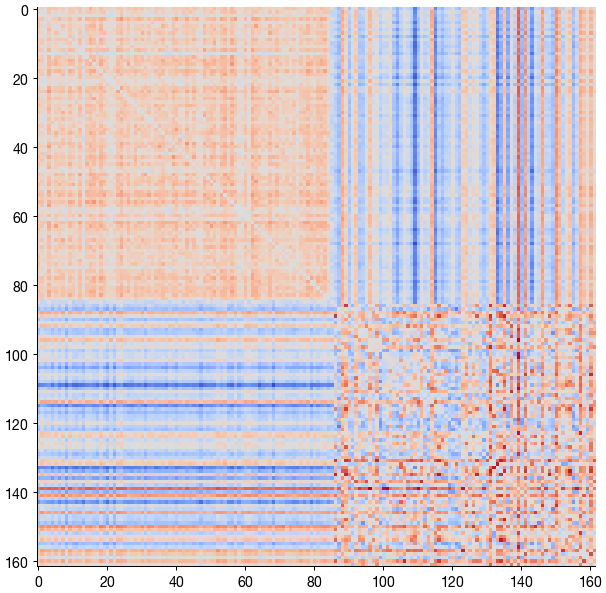

In [91]:
np.fill_diagonal(Mat, np.mean(Mat))
plt.imshow(Mat, cmap='coolwarm')

In [92]:
np.fill_diagonal(Mat, np.nan)
print("relu", np.round(np.nanmean(Mat[:n, :n]),4), "+-", np.round(np.nanstd(Mat[:n, :n]),4))
print("tanh", np.round(np.nanmean(Mat[n:, n:]),4), "+-", np.round(np.nanstd(Mat[n:, n:]),4))
print("relu vs. tanh", np.round(np.nanmean(Mat[:n, n:]),4),"+-", np.round(np.nanstd(Mat[:n, n:]),4))

relu 0.8219 +- 0.0127
tanh 0.811 +- 0.0341
relu vs. tanh 0.8137 +- 0.0282


In [93]:
mds = MDS(n_components=2, dissimilarity='precomputed', n_init=101, eps=1e-6, max_iter=1000)
if method == 'correlation':
    np.fill_diagonal(Mat, 1)
    mds.fit(np.sqrt(2 - 2 * Mat))
elif method == 'MSE':
    np.fill_diagonal(Mat, 0)
    mds.fit(Mat)

/Users/tolmach/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


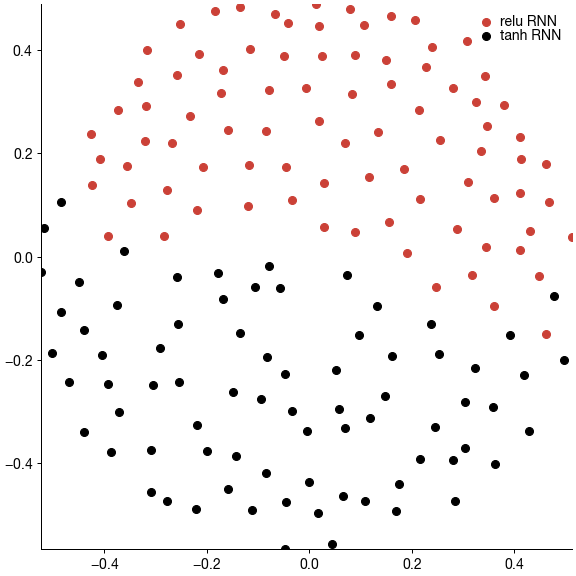

In [94]:
# %matplotlib notebook
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
plt.scatter(mds.embedding_[:n_relu, 0],mds.embedding_[:n_relu, 1], color='r', label='relu RNN')
plt.scatter(mds.embedding_[n_relu:, 0],mds.embedding_[n_relu:, 1], color='b', label='tanh RNN')
plt.legend()
plt.show()

# Analysis of LCs

In [108]:
method = 'correlation'
reg = 10
k = 30
Mat_LC = np.zeros((len(list_of_LC_features),len(list_of_LC_features)))
for i in tqdm(range(len(list_of_LC_features))):
    for j in range(i+1, len(list_of_LC_features)):
        Mat_LC[i, j] = get_similarity(list_of_LC_features[i], list_of_LC_features[j], method=method, reg=reg, k=k)
Mat_LC = (Mat_LC + Mat_LC.T) 

  0%|          | 0/162 [00:00<?, ?it/s]

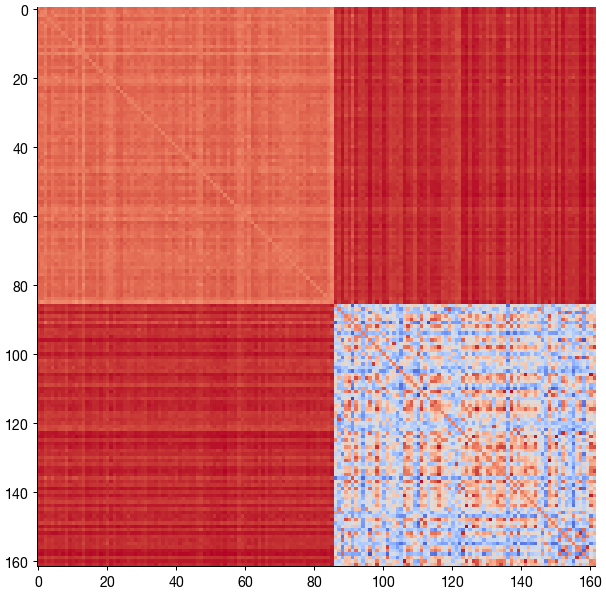

In [109]:
np.fill_diagonal(Mat_LC, np.mean(Mat_LC))
plt.imshow(Mat_LC, cmap='coolwarm')

In [110]:
np.fill_diagonal(Mat_LC, np.nan)
print("relu", np.round(np.nanmean(Mat_LC[:n, :n]),4), "+-", np.round(np.nanstd(Mat_LC[:n, :n]),4))
print("tanh", np.round(np.nanmean(Mat_LC[n:, n:]),4), "+-", np.round(np.nanstd(Mat_LC[n:, n:]),4))
print("relu vs. tanh", np.round(np.nanmean(Mat_LC[:n, n:]),4),"+-", np.round(np.nanstd(Mat_LC[:n, n:]),4))

relu 0.94 +- 0.0074
tanh 0.9349 +- 0.0692
relu vs. tanh 0.9603 +- 0.0198


In [111]:
mds = MDS(n_components=2, dissimilarity='precomputed', n_init=101, eps=1e-6, max_iter=1000)
if method == 'correlation':
    np.fill_diagonal(Mat_LC, 1)
    mds.fit(np.sqrt(2 - 2 * Mat_LC))
elif method == 'MSE':
    np.fill_diagonal(Mat_LC, 0)
    mds.fit(Mat_LC)

/Users/tolmach/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


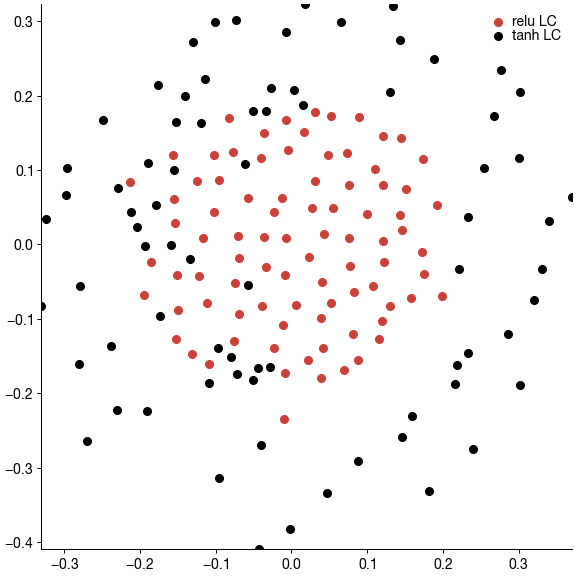

In [112]:
# %matplotlib notebook
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
plt.scatter(mds.embedding_[:n_relu, 0],mds.embedding_[:n_relu, 1], color='r', label='relu LC')
plt.scatter(mds.embedding_[n_relu:, 0],mds.embedding_[n_relu:, 1], color='b', label='tanh LC')
plt.legend()
plt.show()